In [1]:
import pandas as pd
import yaml
import os
import cdt
import networkx as nx
from ipumspy import readers
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import sklearn

pd.set_option("display.max_columns", 500)
sklearn.set_config(transform_output="pandas")
cdt.SETTINGS.rpath = "C:\\Program Files\\R\\R-4.3.2\\bin\\Rscript"

Detecting 1 CUDA device(s).


## Data Loading and Cleaning

In [2]:
# load config
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
data_name = config["data_name"]
col_filter_title = config["column_filter_title"]

# load data
pkl_path = f"data/{data_name}.pkl"
xml_path = f"data/{data_name}.xml"
dat_path = f"data/{data_name}.dat"
col_info_path = f"data/{data_name}_columns_info.csv"

assert os.path.exists(pkl_path) or (
    os.path.exists(xml_path) and os.path.exists(dat_path)
), "Ensure that the data_name in config corresponds to file in the data folder"

if os.path.exists(pkl_path):
    df = pd.read_pickle(pkl_path)
    print(f'Loaded from "{pkl_path}"')
else:
    print("Loading through the ipums reader...")
    ddi_codebook = readers.read_ipums_ddi(xml_path)
    df = readers.read_microdata(ddi_codebook, dat_path)
    print(f'Read from "{xml_path}" and "{dat_path}"')

    pkl_path = f"data/{data_name}.pkl"
    print(f'Saving pickle to "{pkl_path}"')
    df.to_pickle(pkl_path)
    print("Saved!")

Loaded from "data/cps_00001.pkl"


Now parse in the xml information on the columns because otherwise the column names are unintelligble. Creating the 'col_info' dictionary also allows for easy mapping for column names and categorical variable codes for easier interpretation going forward

In [3]:
tree = ET.parse(xml_path)
root = tree.getroot()

# bringing in column information into a format that is easily accessible for
# future data sorting
col_info = {}
for i in range(len(root[3])):
    id = root[3][i].attrib["ID"]
    col_info[id] = {}
    col_info[id]["short_desc"] = root[3][i][1].text
    col_info[id]["interval"] = root[3][i].attrib["intrvl"]
    col_info[id]["long_desc"] = root[3][i][2].text
    category_dict = {}
    for category in root[3][i].findall("{ddi:codebook:2_5}catgry"):
        category_dict[int(category[0].text)] = category[1].text
    col_info[id]["category_dict"] = category_dict

# this can be used with rename method to make it clear what I am looking for
easy_col_names = {i: col_info[i]["short_desc"] for i in col_info.keys()}

In [4]:
# add a datetime field for easy querying
df["Day"] = 1
df["datetime"] = pd.to_datetime(df[["YEAR", "MONTH", "Day"]])
df = df.drop(columns=["Day"])

# limit df to a single 2023 ASEC survey NOTE delete this line with different data
df = df.query("YEAR==2023 and ASECFLAG== 1").copy()

# it looks like all columns are either ALL na or no NA, so this is safe
df = df.dropna(axis=1)

Lets figure out which columns to analyze going forward based on the current dataset. The best way I could find to do this was to save it to a csv, add a new field for whether or not to include in the analysis, and then load that information in. The appeal of this method is 
1. Easily see the full description and all variable information when making the decision 
2. See alternatives easily, such as considering 1990 or current industry definition and 
3. Can create different column filters for different filters

In [5]:
if os.path.exists(col_info_path):
    print(
        f"Reading from the column '{col_filter_title}' from the file '{col_info_path}'. Any columns with 1 will be included."
    )
    temp = pd.read_csv(col_info_path)
    assert (
        col_filter_title in temp.columns
    ), f"Ensure '{col_filter_title}' is a column in '{col_info_path}'"
    cols_to_include = temp.loc[temp[col_filter_title] == 1]["Unnamed: 0"].unique()
    df = df[cols_to_include]
else:
    print(f"No file found at '{col_info_path}'. Creating a new csv.")
    col_info_df = pd.DataFrame.from_dict(
        {c: col_info[c] for c in col_info if c in df.columns}, orient="index"
    )
    col_info_df[col_filter_title] = ""
    col_info_df.to_csv(col_info_path)

Reading from the column 'analysis_group_1' from the file 'data/cps_00001_columns_info.csv'. Any columns with 1 will be included.


## Exploratory Data Analysis

In [6]:
df["RACE"].map(col_info["RACE"]["category_dict"]).value_counts()

RACE
White                                                    111621
Black                                                     17187
Asian only                                                 9875
American Indian/Aleut/Eskimo                               2195
White-Black                                                1324
White-American Indian                                      1168
White-Asian                                                 921
Hawaiian/Pacific Islander only                              882
Black-American Indian                                       171
White-Hawaiian/Pacific Islander                             154
White-Asian-Hawaiian/Pacific Islander                       147
Asian-Hawaiian/Pacific Islander                             145
White-Black-American Indian                                 123
Black-Asian                                                  65
White-Black-Asian                                            34
Four or five races, unspecified    

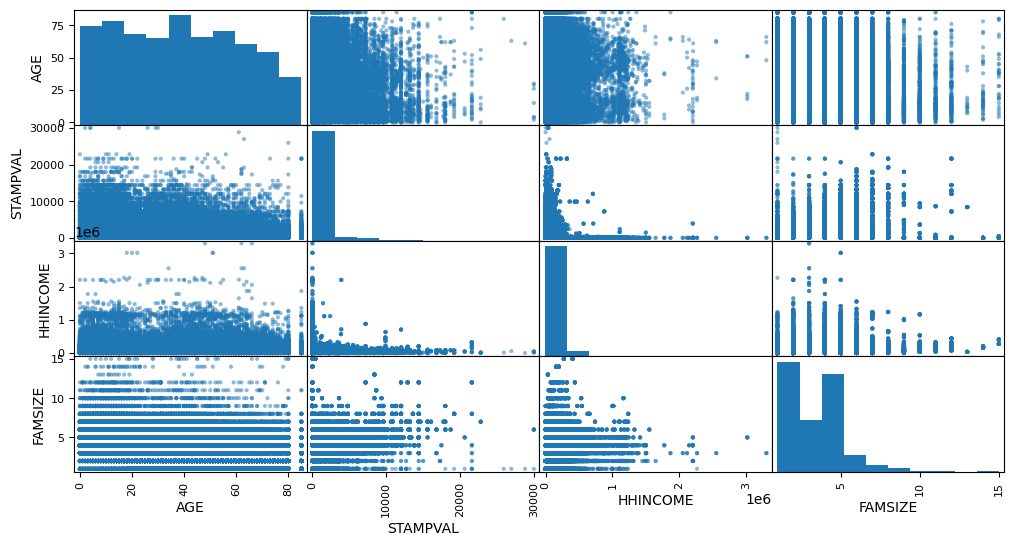

In [10]:
pd.plotting.scatter_matrix(
    df[["AGE", "STAMPVAL", "HHINCOME", "FAMSIZE"]], figsize=(12, 6)
)
plt.show()

## Casual Discovery Functions

First, limit the data set size so to allow for quicker testing

In [8]:
from sklearn.model_selection import train_test_split


def interval_filter(
    df: pd.DataFrame,
    col_info: dict,
    contin_or_discrete: str,
) -> pd.DataFrame:
    assert contin_or_discrete in [
        "contin",
        "discrete",
    ], 'contin_or_discrete must be either "contin" or "discrete"'

    cols = [
        i
        for i in col_info
        if (col_info[i]["interval"] == contin_or_discrete and i in df.columns)
    ]
    return df[cols]


def random_shrink(
    df: pd.DataFrame,
    rows_to_return: int,
    random_state: int = 42,
) -> pd.DataFrame:
    assert rows_to_return > 0, "rows_to_return must be positive"
    portion = min(1, (rows_to_return / df.shape[0]))
    _, small = train_test_split(df, test_size=portion, random_state=random_state)
    return small

Running the different cdt algorithms are very simple -- just change which is called. However, interpreting the results is more difficult and what I will do in the next stage of the project

In [15]:
model = cdt.causality.graph.GES()
output = model.predict(df)

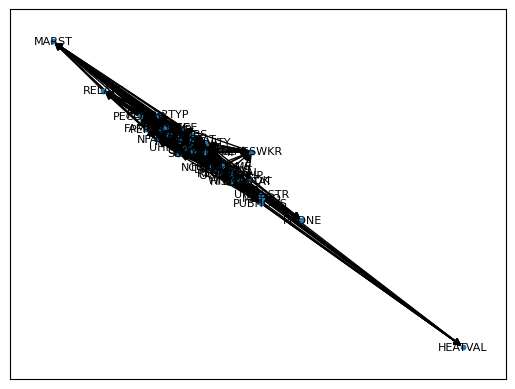

In [17]:
nx.draw_networkx(output, font_size=8,node_size=10)
plt.show()

In [ ]:
glasso = cdt.independence.graph.Glasso()
skeleton = glasso.predict(data)
print(skeleton)

In [ ]:
nx.draw(graph)